In [11]:
import numpy as np
import matrix_utils as utils
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt


def parse_inputs(x):
    beta, alpha, emittance = x
    gamma = (1+alpha**2)/beta

    emittance = emittance*1e-7
    return beta, alpha, gamma, emittance

def print_results(x, energy, coord):
    rel_gamma = energy / 511000
    beta, alpha, gamma, emittance = parse_inputs(x)

    print(f'---------- {coord} ----------')
    print(f'Emittance: {emittance:.2e}')
    print(f'Norm. Emittance: {rel_gamma*emittance:.2e}')
    print(f'Beta Twiss: {beta:.2f}')
    print(f'Alpha Twiss: {alpha:.2f}')
    return

def errorfcn(x, measurements, rigidity, cam):
    beta, alpha, gamma, emittance = parse_inputs(x)

    beam_initial = emittance * np.array([
        [beta, -alpha],
        [-alpha, gamma]
    ])

    error = 0
    for _, meas in measurements.iterrows():
        full_matrix = utils.compute_transport_matrix(meas.Q1, meas.Q2, meas.Q3, rigidity, cam)
        beam_final = full_matrix.dot(beam_initial.dot(full_matrix.T))
        pred_spotsize = np.sqrt(beam_final[0,0])*1e6 if beam_final[0,0]>0 else 1000
        error += (meas.spotsize - pred_spotsize)**2

    return error

def plot_fit_vs_data(x, measurements, rigidity, cam):
    beta, alpha, gamma, emittance = parse_inputs(x)

    beam_initial = emittance * np.array([
        [beta, -alpha],
        [-alpha, gamma]
    ])

    pred_spotsizes = []
    for _, meas in measurements.iterrows():
        full_matrix = utils.compute_transport_matrix(meas.Q1, meas.Q2, meas.Q3, rigidity, cam)
        beam_final = full_matrix.dot(beam_initial.dot(full_matrix.T))
        pred_spotsizes.append(np.sqrt(beam_final[0,0])*1e6)
    measurements['pred_spotsize'] = pred_spotsizes

    fig, ax = plt.subplots()
    ax.scatter(measurements.Q2, measurements.spotsize, label='Beam Data')
    ax.scatter(measurements.Q2, measurements.pred_spotsize, label='Simulation Fit')
    ax.legend()
    return fig, ax



In [51]:
# Specify beam energy
energy = 80e6 #eV
rigidity = energy/299792458

# Read data
dataset = '../../Scans/2024-08-13/Quadscan.csv'
cam = 'cam5'

# dataset = '../../Scans/2024-08-09/Quadscan.csv'
# cam = 'cam4'
df = pd.read_csv(dataset)


# Remove bad data
df = df[df.Q2<-1]

# Multiply pixels by calibration (express in um)
calibration = df.calibration[0]
df.xrms *= calibration
df.yrms *= calibration
df = df[['Q1', 'Q2', 'Q3', 'xrms', 'yrms']]

# Prepare measurements for each
xdf = df.rename(columns={'xrms': 'spotsize'})
ydf = df.rename(columns={'yrms': 'spotsize'})
ydf[['Q1', 'Q2', 'Q3']] = -1*ydf[['Q1', 'Q2', 'Q3']]
ydf = ydf[ydf.spotsize<1000]

# Run optimizer (emittance scaled by 1e8)
bounds = [(0.1, 2), (-5, 5), (.01, 10)] 
x0 = [1, 0, 3]
xresult = minimize(lambda x: errorfcn(x, xdf, rigidity, cam), x0, method='L-BFGS-B', bounds=bounds)
yresult = minimize(lambda x: errorfcn(x, ydf, rigidity, cam), x0, method='L-BFGS-B', bounds=bounds)

print_results(xresult.x, energy, 'X')
print_results(yresult.x, energy, 'Y')

---------- X ----------
Emittance: 8.39e-08
Norm. Emittance: 1.31e-05
Beta Twiss: 1.22
Alpha Twiss: -0.56
---------- Y ----------
Emittance: 3.17e-08
Norm. Emittance: 4.96e-06
Beta Twiss: 0.52
Alpha Twiss: -0.39


Text(0.5, 1.0, 'Confirm Fit')

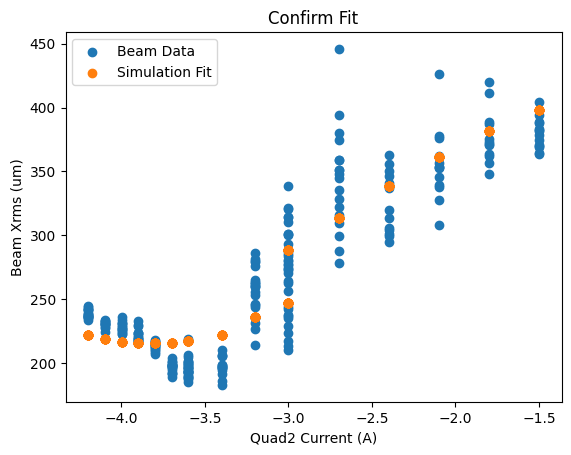

In [52]:
# Plot against data
x0 = [.3, -.3, .7]
# print_results(x0, energy, 'x')

fig, ax = plot_fit_vs_data(xresult.x, xdf, rigidity, cam)
# fig, ax = plot_fit_vs_data(x0, xdf, rigidity, cam)
ax.set_xlabel('Quad2 Current (A)')
ax.set_ylabel('Beam Xrms (um)')
ax.set_title('Confirm Fit')


# plot_fit_vs_data(yresult.x, ydf, rigidity, cam)
